In [1]:
import pyaudio
import audioop
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTr

In [79]:
class TapDetector():
    def __init__(this,channels,rate,index,frames,chunk,tapSize):
        this.audio = pyaudio.PyAudio()
        this.fullFrames = np.full((tapSize,chunk),None,dtype='float64')
        this.frames = np.zeros(tapSize)
        this.all = []
        this.tapSize = tapSize
        this.currentFrame = 0
        this.chunk = chunk
        this.rate = rate
        this.cooldown =0
        this.trainingSets = []
        this.negativeTrainingSet = []
        this.clf = None
        this.classifier = KNeighborsClassifier(1)
        this.stream = this.audio.open(format = pyaudio.paInt16,
                                      channels = channels,
                                      rate = rate,
                                      input = True,
                                      input_device_index = index,
                                      frames_per_buffer = frames)
    
    def start(this,seconds):
        print("Recording Started")
        print(not this.clf == None)
        for i in range(0,int(this.rate / this.chunk * seconds)):
            if this.record():
                if not this.clf == None:
                    flat = np.array([np.array(x).flatten() for x in this.fullFrames]).flatten()
                    prediction = this.clf.predict([flat])
                    print(prediction)
        print("Recording Finnished")
        plt.plot(this.all)
        plt.show()
    
    def getFrequency(this,data):
        return data
        fft = np.abs(np.fft.fft(data).real)
        fft = fft[:int(len(fft)/2)]
        freq = np.fft.fftfreq(this.chunk,1./this.rate)
        freq = freq[:int(len(freq)/2)]
        #print(fft[np.where(freq>0)[0][0]],20*np.log10(np.abs(np.fft.rfft(data))))
        return np.abs(np.fft.rfft(data))
        return 20*np.log10(np.abs(np.fft.rfft(data)))
    
    def record(this):
        tapFound = False
        data = this.stream.read(this.chunk, exception_on_overflow=False)
        decoded = np.frombuffer(data, dtype='<i2')#np.fromstring(data.hex(), 'Float32').tolist()
        #plt.plot(decoded)
        #print(decoded)
        #plt.show()
        this.all.append(audioop.rms(data, 2))
        this.frames[this.currentFrame] = audioop.rms(data, 2)
        this.fullFrames[this.currentFrame] = this.getFrequency(decoded)
        this.currentFrame = (this.currentFrame+1)%this.tapSize
        if(this.cooldown <= 0):
            tapFound = this.isTap(9000)
            return tapFound
        else:
            this.cooldown -= 1
        return tapFound
    
    def callibrate(this,buttons,tapsNeeded):
        for button in range(0,buttons):
            this.trainingSets.append([])
            print("Callibrating button position {}".format(button))
            for tap in range(1,tapsNeeded+1):
                while(not this.record()):
                    d = 1
                this.trainingSets[button].append(this.fullFrames.copy())
                print("{}/{} taps registered for button {}".format(tap,tapsNeeded,button))
        for tap in range(1,tapsNeeded+1):
            print("Tap at a place with no button")
            while(not this.record()):
                d = 1
            this.negativeTrainingSet.append(this.fullFrames.copy())
            print("{}/{} false taps registered so far".format(tap,tapsNeeded))
        this.buttonTraining()

    def buttonTraining(this):
        positiveTrainX = [np.array(x).flatten() for x in this.trainingSets[0]]
        positiveTrainY = np.full( len(positiveTrainX), 5)
        negativeTrainX = [np.array(x).flatten() for x in this.negativeTrainingSet]
        negativeTrainY = np.full( len(negativeTrainX), -1)
        trainX = positiveTrainX
        trainX.extend(negativeTrainX)
        trainY = np.hstack([positiveTrainY,negativeTrainY])
        this.clf = this.classifier.fit(trainX,trainY)
        print(this.clf.predict(trainX))
        
    def stop(this):
        this.stream.stop_stream()
        this.stream.close()
    
    def plot(this):
        plt.plot(np.hstack([this.frames[this.currentFrame:],this.frames[:this.currentFrame]]))
        print(this.fullFrames)
        plt.show()
    
    def isTap(this,threshold):
        soundSlice = np.hstack([this.frames[this.currentFrame:],this.frames[:this.currentFrame]])
        freqSlice = np.vstack([this.fullFrames[this.currentFrame:],this.fullFrames[:this.currentFrame]])
        diff = np.diff(soundSlice)
        maxPeaks = argrelextrema(soundSlice, np.greater)
        if len(maxPeaks) > 0:
            maxPeaks = maxPeaks[0].tolist()
        if len(maxPeaks) == 0:
            return False
        if soundSlice[maxPeaks[0]] > threshold and diff[maxPeaks[0]]**2 > 5000 and maxPeaks[0] > 1:
            for i in range(1,len(maxPeaks)):
                if soundSlice[maxPeaks[i]] > (soundSlice[maxPeaks[0]] * 0.5):
                    return False
            this.cooldown = 50//2
            for freq in freqSlice:
                plt.plot(freq)
            plt.show()
            plt.plot(freqSlice[maxPeaks[0]])
            plt.show()
            return True
        return False
                   
    

Callibrating button position 0


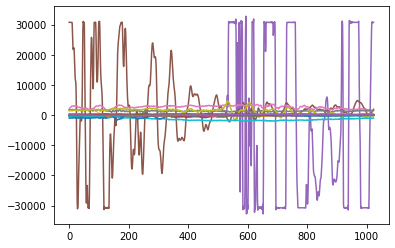

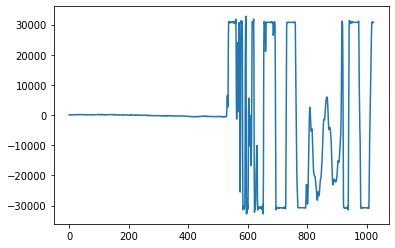

1/2 taps registered for button 0


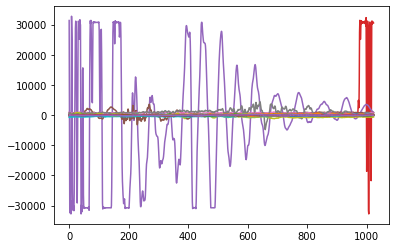

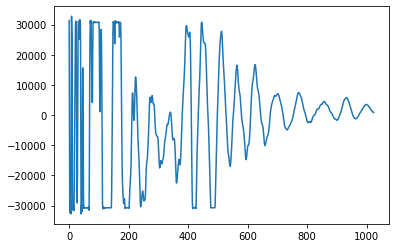

2/2 taps registered for button 0
Tap at a place with no button


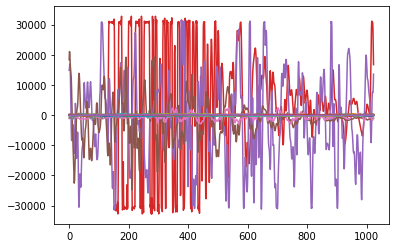

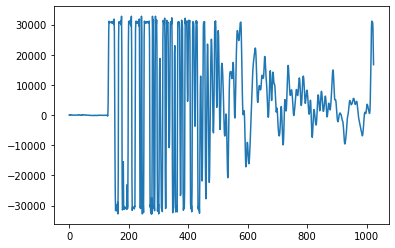

1/2 false taps registered so far
Tap at a place with no button


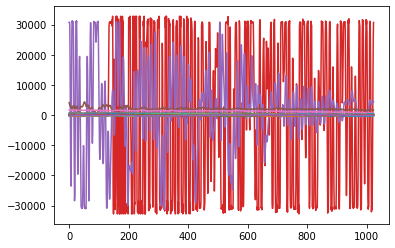

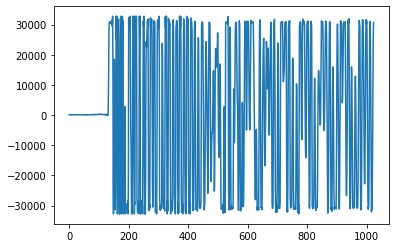

2/2 false taps registered so far
[ 5  5 -1 -1]
Recording Started
True


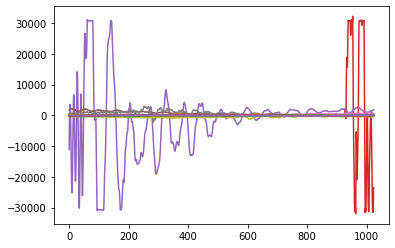

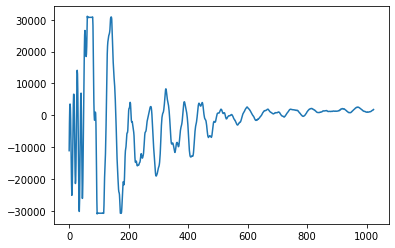

[5]


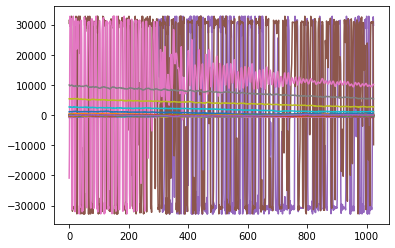

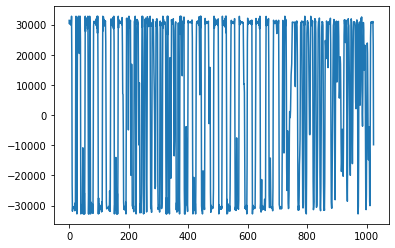

[5]


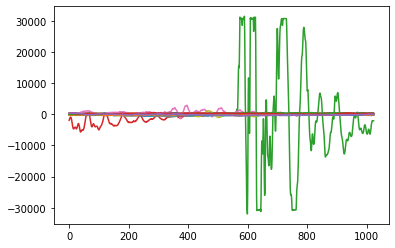

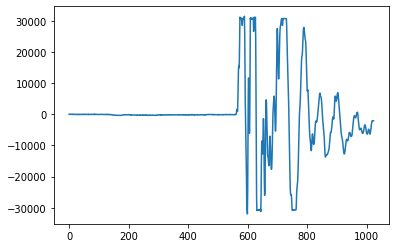

[5]


KeyboardInterrupt: 

In [80]:
channels =1
rate = 44100
index = 0
frames = 5
chunk = 1024
tapSize = 25
detector = TapDetector(channels,rate,index,frames,chunk,tapSize)
detector.callibrate(1,2)
detector.start(60)
detector.plot()
detector.stop()

In [ ]:
        
    def findPeaks(this,soundSlice,threshold):
        diff = np.diff(soundSlice)
        startPeak,startId = 0,0
        lowPeak,lowId = 0,0
        afterPeak, afterId = 0,0
        index = 0
        for db in soundSLice:
            index += 1
            if(lowId = 0 and db > 0 and db > startPeak and db >= threshold):
                startPeak = db
                startId = index
            elif(afterId = 0 and db < 0 and db < lowPeak):
                lowPeak = db,
                lowId = index
            elif(index > lowId and db > 0 and db > afterPeak):
                afterPeak = db
                afterId = index
            elif(after)